In [1]:
import torch

In [2]:
from utils import assign_splits, get_label_mapping

mbti_to_idx = get_label_mapping(
    file_path="faces_yolo_id_split_metadata.csv",
    label_column="mbti",
)


print("MBTI to index mapping:", mbti_to_idx)

MBTI to index mapping: {'ENFJ': 0, 'ENFP': 1, 'ENTJ': 2, 'ENTP': 3, 'ESFJ': 4, 'ESFP': 5, 'ESTJ': 6, 'ESTP': 7, 'INFJ': 8, 'INFP': 9, 'INTJ': 10, 'INTP': 11, 'ISFJ': 12, 'ISFP': 13, 'ISTJ': 14, 'ISTP': 15}


In [3]:
from torchvision import transforms

train_tf = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(0.25, 0.25, 0.25, 0.05)], p=0.8),
        transforms.RandomApply(
            [
                transforms.RandomAffine(
                    degrees=10,  # small rotation
                    translate=(0.05, 0.05),  # small shifts
                    scale=(0.9, 1.1),
                )
            ],
            p=0.5,
        ),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.ToTensor(),
        transforms.RandomErasing(
            p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3), value="random"
        ),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

val_tf = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [4]:
from torch.utils.data import DataLoader
from dataset import IDSplitCelebMBTIDataset

root_dir = "faces_yolo_id_split_384"
metadata_csv = "faces_yolo_id_split_384_metadata.csv"

train_ds = IDSplitCelebMBTIDataset(
    root_dir=root_dir,
    metadata_csv=metadata_csv,
    split="train",
    mbti_to_idx=mbti_to_idx,
    transform=train_tf,
)

val_ds = IDSplitCelebMBTIDataset(
    root_dir=root_dir,
    metadata_csv=metadata_csv,
    mbti_to_idx=mbti_to_idx,
    split="val",
    transform=val_tf,
)

test_ds = IDSplitCelebMBTIDataset(
    root_dir=root_dir,
    metadata_csv=metadata_csv,
    mbti_to_idx=mbti_to_idx,
    split="test",
    transform=val_tf,
)

print(len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)

for images, labels in train_loader:
    print(images.shape)  # [Batch, 3, 224, 224]
    print(labels.shape)  # [Batch, 4]
    break

9569 1193 1217
torch.Size([32, 3, 384, 384])
torch.Size([32])


In [5]:
from models import MBTIEfficientNetV2Small
import torch.nn as nn
from tqdm import tqdm

efficientnet_weights = "efficientnetv2_affectnet_best.pth"
num_ftrs = 1280
num_classes = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MBTIEfficientNetV2Small(freeze_backbone=True, num_classes=8)
model.load_state_dict(torch.load(efficientnet_weights))

model.model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_ftrs, 128),
    nn.BatchNorm1d(128),  # Helps stability
    nn.ReLU(),
    nn.Dropout(0.5),  # Critical for your small dataset
    nn.Linear(128, num_classes),  # Output num_classes logits
)

model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# for name, param in model.named_parameters():
#     print(name, param.data)
# print(model.parameters())

In [6]:
# train on frozen backbone for a few epochs
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

for epoch in range(1, 9):
    # training phase with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)

        # print(logits.shape, y.shape)  # Debugging line
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total_loss += loss.item() * y.size(0)
        total += y.size(0)

        pbar.set_postfix(loss=loss.item())

    tr_loss = total_loss / total
    tr_acc = total_correct / total

    # validation phase with tqdm
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            preds = logits.argmax(1)
            total_correct += (preds == y).sum().item()
            total_loss += loss.item() * y.size(0)
            total += y.size(0)

            pbar.set_postfix(loss=loss.item())

    va_loss = total_loss / total
    va_acc = total_correct / total

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f}/ train accuracy {tr_acc:.3f} | "
        f"val loss {va_loss:.4f}/ val accuracy {va_acc:.3f}"
    )

Epoch 01 | train loss 2.8687/ train accuracy 0.070 | val loss 2.7620/ val accuracy 0.098


Epoch 02 | train loss 2.7997/ train accuracy 0.088 | val loss 2.7506/ val accuracy 0.100


Epoch 03 | train loss 2.7792/ train accuracy 0.096 | val loss 2.7431/ val accuracy 0.101


Epoch 04 | train loss 2.7625/ train accuracy 0.103 | val loss 2.7364/ val accuracy 0.102


Epoch 05 | train loss 2.7449/ train accuracy 0.107 | val loss 2.7345/ val accuracy 0.099


Epoch 06 | train loss 2.7305/ train accuracy 0.110 | val loss 2.7335/ val accuracy 0.102


Epoch 07 | train loss 2.7234/ train accuracy 0.119 | val loss 2.7370/ val accuracy 0.110


Epoch 08 | train loss 2.7158/ train accuracy 0.116 | val loss 2.7318/ val accuracy 0.106


In [7]:

# unfreeze backbone
for param in model.parameters():
    param.requires_grad = True

train_accs = []
val_accs = []
train_losses = []
val_losses = [] 

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
for epoch in range(20):
    # training phase with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)

        # print(logits.shape, y.shape)  # Debugging line
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total_loss += loss.item() * y.size(0)
        total += y.size(0)

        pbar.set_postfix(loss=loss.item())

    tr_loss = total_loss / total
    tr_acc = total_correct / total

    # validation phase with tqdm
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            preds = logits.argmax(1)
            total_correct += (preds == y).sum().item()
            total_loss += loss.item() * y.size(0)
            total += y.size(0)

            pbar.set_postfix(loss=loss.item())

    va_loss = total_loss / total
    va_acc = total_correct / total

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f}/ train accuracy {tr_acc:.3f} | "
        f"val loss {va_loss:.4f}/ val accuracy {va_acc:.3f}"
    )

Epoch 00 | train loss 2.6994/ train accuracy 0.127 | val loss 2.7296/ val accuracy 0.111


Epoch 01 | train loss 2.6793/ train accuracy 0.135 | val loss 2.7296/ val accuracy 0.116


Epoch 02 | train loss 2.6553/ train accuracy 0.148 | val loss 2.7291/ val accuracy 0.105


Epoch 03 | train loss 2.6360/ train accuracy 0.151 | val loss 2.7368/ val accuracy 0.104


Epoch 04 | train loss 2.6221/ train accuracy 0.156 | val loss 2.7328/ val accuracy 0.116


Epoch 05 | train loss 2.5986/ train accuracy 0.175 | val loss 2.7318/ val accuracy 0.111


Epoch 06 | train loss 2.5706/ train accuracy 0.186 | val loss 2.7319/ val accuracy 0.110


Epoch 07 | train loss 2.5608/ train accuracy 0.190 | val loss 2.7357/ val accuracy 0.105


Epoch 08 | train loss 2.5255/ train accuracy 0.213 | val loss 2.7417/ val accuracy 0.111


Epoch 09 | train loss 2.5140/ train accuracy 0.213 | val loss 2.7459/ val accuracy 0.111


Epoch 10 | train loss 2.4884/ train accuracy 0.224 | val loss 2.7434/ val accuracy 0.115


Epoch 11 | train loss 2.4630/ train accuracy 0.244 | val loss 2.7494/ val accuracy 0.114


Epoch 12 | train loss 2.4275/ train accuracy 0.262 | val loss 2.7515/ val accuracy 0.113


Epoch 13 | train loss 2.4055/ train accuracy 0.281 | val loss 2.7509/ val accuracy 0.116


Epoch 14 | train loss 2.3724/ train accuracy 0.288 | val loss 2.7669/ val accuracy 0.105


Epoch 15 | train loss 2.3394/ train accuracy 0.317 | val loss 2.7718/ val accuracy 0.101


KeyboardInterrupt: 

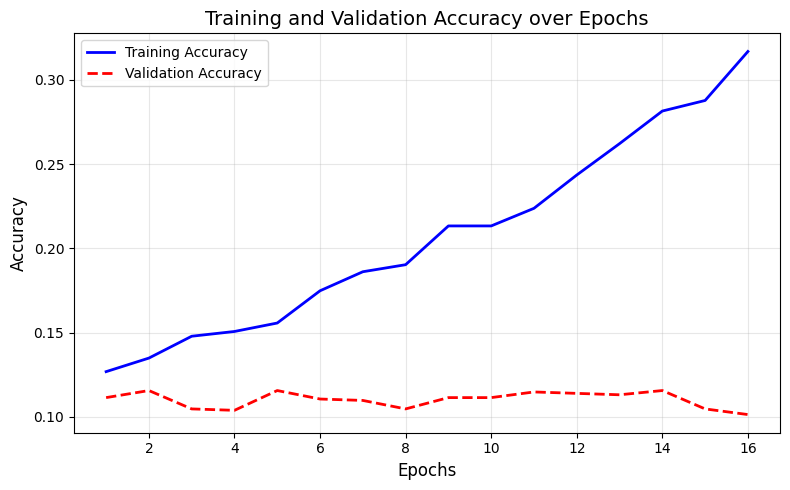

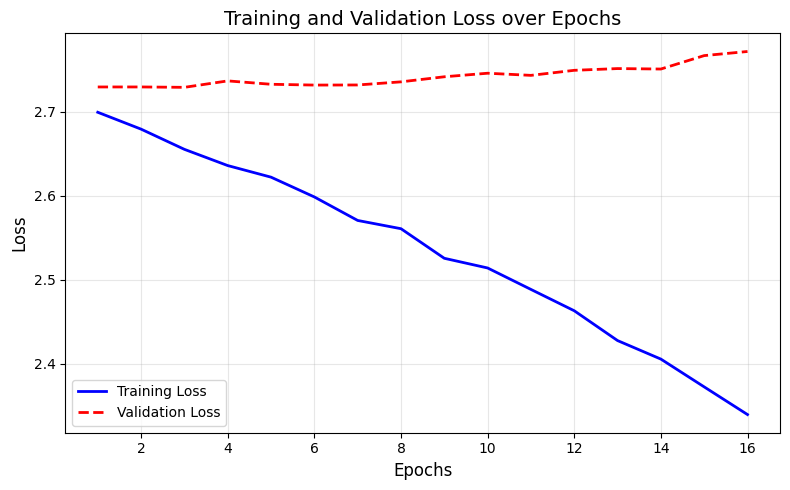

In [8]:
import matplotlib.pyplot as plt
from utils import plot_metric, plot_confusion_matrix

plot_metric(
    train_values=train_accs,
    val_values=val_accs,
    title="Training and Validation Accuracy over Epochs",
    ylabel="Accuracy",
)

plot_metric(
    train_values=train_losses,
    val_values=val_losses,
    title="Training and Validation Loss over Epochs",
    ylabel="Loss",
)

Generating predictions for Confusion Matrix...


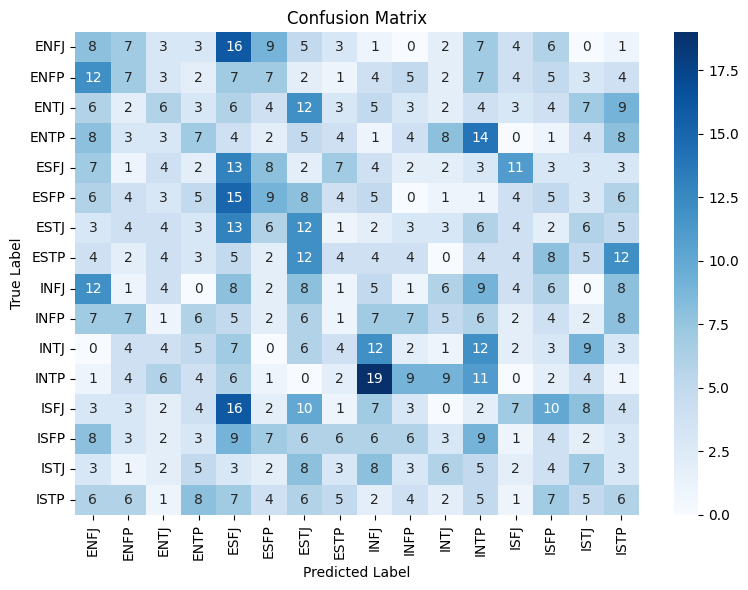


--- Per-Class Accuracy ---
ENFJ: 10.67%
ENFP: 9.33%
ENTJ: 7.59%
ENTP: 9.21%
ESFJ: 17.33%
ESFP: 11.39%
ESTJ: 15.58%
ESTP: 5.19%
INFJ: 6.67%
INFP: 9.21%
INTJ: 1.35%
INTP: 13.92%
ISFJ: 8.54%
ISFP: 5.13%
ISTJ: 10.77%
ISTP: 8.00%


In [9]:
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

plot_confusion_matrix(
    model=model,
    loader=test_dl,
    device=device,
    class_names=list(mbti_to_idx.keys())
)

In [10]:
torch.save(model.state_dict(), "efficientnetv2_mbti_classification.pth") 